# Data analysis HUPA0003P patient

In order to clarify our vision, we take a single patient HUPA0003P 

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 

For this notebook, we are following Box-Jenkins methodology

## Get data and visualize the data 

In [2]:
data = pd.read_csv('../Data/Preprocessed/HUPA0003P.csv', sep=';')[['time', 'glucose', 'bolus_volume_delivered', 'carb_input']]

In [3]:
data['time'] = pd.to_datetime(data['time'])
data

,time,glucose,bolus_volume_delivered,carb_input
0,2018-06-13 21:40:00,137.666667,0.0,0.0
1,2018-06-13 21:45:00,137.000000,0.0,0.0
2,2018-06-13 21:50:00,136.333333,0.0,0.0
3,2018-06-13 21:55:00,135.666667,0.0,0.0
4,2018-06-13 22:00:00,135.000000,0.0,0.0
...,...,...,...,...
3765,2018-06-26 23:25:00,160.666667,0.0,0.0
3766,2018-06-26 23:30:00,158.000000,0.0,0.0
3767,2018-06-26 23:35:00,159.000000,0.0,0.0
3768,2018-06-26 23:40:00,160.000000,0.0,0.0


Firstly visualize the whole data 

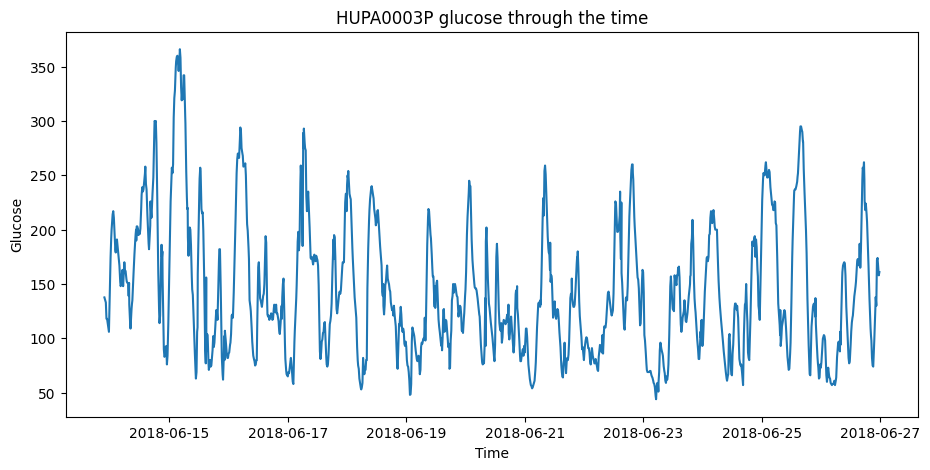

In [4]:
figure, ax = plt.subplots(1,1, figsize=(11, 5))
ax.plot(data['time'], data['glucose'])
ax.set(title='HUPA0003P glucose through the time', xlabel='Time', ylabel='Glucose')
plt.show()

Now, we visualize just one day 

In [5]:
def get_ticks(size_window, array_dates):
    index_ticks = []
    j = 0 
    i = 0
    while j != 288: ## A day contains 288 samples
        i = j
        index_ticks.append(i)
        j += size_window
    ticks = array_dates[index_ticks]
    label_ticks = ticks.dt.strftime('%Y/%m/%d %H:%M')
    return ticks, label_ticks


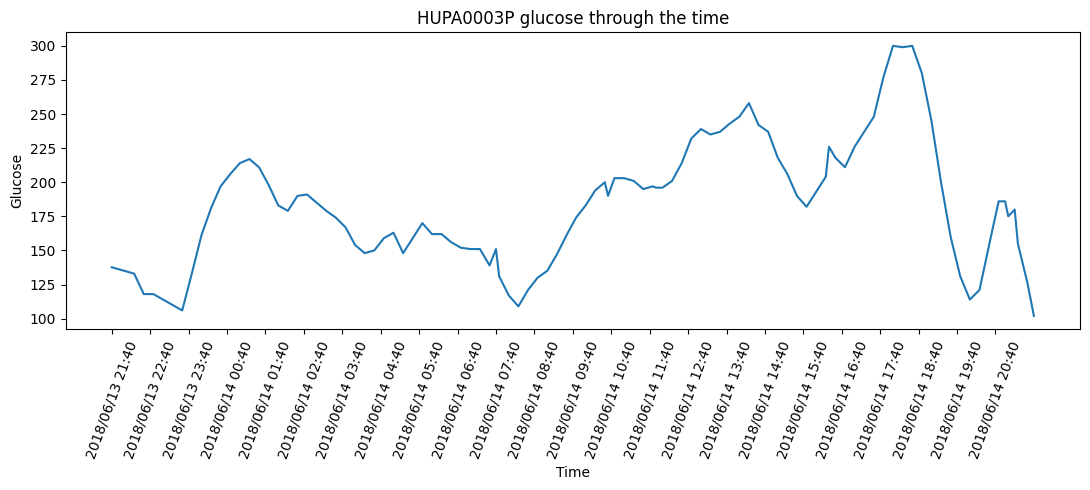

In [6]:
one_day = data[:289]
figure, ax = plt.subplots(1,1, figsize=(11, 5))
ticks, ticks_labels = get_ticks(12, array_dates=data['time'])
ax.plot(one_day['time'], one_day['glucose'])
ax.set(title='HUPA0003P glucose through the time', xlabel='Time', ylabel='Glucose')
ax.set_xticks(ticks)  
ax.set_xticklabels(ticks_labels, rotation=70)
plt.tight_layout()
plt.show()

**Insulin to Carb Ratio (ICR)**

The ICR represents the number of grams of carbohydrate that 1 unit of rapid-acting insulin will cover. This ratio is highly individualized and varies from person to person.

Formula:
$
ICR = \text{Grams of Carbohydrate Eaten} / \text{Units of Rapid-Acting Insulin Taken}
$

Key Points:
- **Individual variation**: Each person has a unique ICR that may vary throughout the day
- **Clinical importance**: Proper ICR calculation is crucial for effective diabetes management
- **Monitoring**: Regular blood glucose monitoring helps adjust and validate ICR values

This ratio is fundamental for determining insulin dosing for meals and managing postprandial glucose levels.

In [7]:
data.query('carb_input != 0 & bolus_volume_delivered !=0')

,time,glucose,bolus_volume_delivered,carb_input
120,2018-06-14 07:40:00,151.000000,7.50,7.5
170,2018-06-14 11:50:00,196.000000,1.75,3.5
203,2018-06-14 14:35:00,240.333333,5.70,11.0
207,2018-06-14 14:55:00,224.333333,1.50,2.0
282,2018-06-14 21:10:00,180.000000,3.20,12.0
...,...,...,...,...
3458,2018-06-25 21:50:00,137.000000,2.50,8.0
3578,2018-06-26 07:50:00,106.000000,5.70,7.5
3674,2018-06-26 15:50:00,179.666667,3.70,10.0
3696,2018-06-26 17:40:00,246.000000,0.35,1.0


Let's visualize glucose, carbs and rapid-acting insulin at the same time, in order to visualize it properly, we normalize it 

In [8]:
def normalize(data):
    mean = data.mean()
    std = data.std()
    if std == 0:
        return data - mean
    return (data - mean) / std

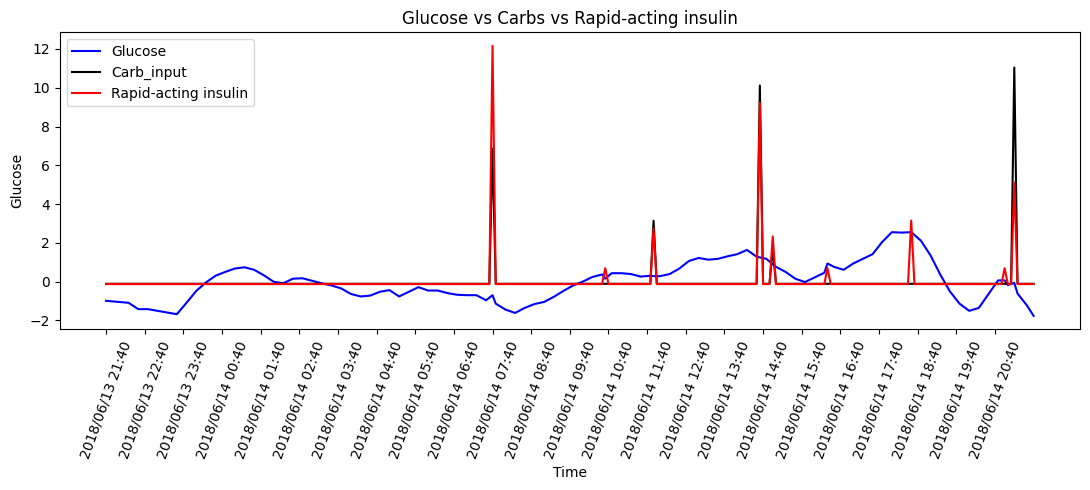

In [9]:
figure, ax = plt.subplots(1,1, figsize=(11, 5))
ticks, ticks_labels = get_ticks(12, array_dates=data['time'])

ax.plot(one_day['time'], normalize(one_day['glucose']), label='Glucose', color='blue')
ax.plot(one_day['time'], normalize(one_day['carb_input']), label='Carb_input', color='black')
ax.plot(one_day['time'], normalize(one_day['bolus_volume_delivered']), label='Rapid-acting insulin', color='red')

ax.set(title='Glucose vs Carbs vs Rapid-acting insulin', xlabel='Time', ylabel='Glucose')
ax.set_xticks(ticks)  
ax.set_xticklabels(ticks_labels, rotation=70)
plt.tight_layout()
plt.legend()
plt.show()

## Stationarity test ADF and KPSS

In [10]:
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.statespace.tools import diff

In [11]:
def apply_tests(data):
    kpss_result = 'Estacionaria' if kpss(data)[1] > 0.05 else 'No estacionaria'
    adf_result = 'No estacionaria' if adfuller(data)[1] > 0.05 else 'Estacionaria'
    print(f'KPSS result : {kpss_result}')
    print(f'ADF result : {adf_result}')


In [12]:
apply_tests(data['glucose'])

KPSS result : No estacionaria
ADF result : Estacionaria


As we could see above results diverge between each statistic test, we apply diff

In [13]:
first_diff = diff(data['glucose'])
apply_tests(first_diff)

KPSS result : Estacionaria
ADF result : Estacionaria


/tmp/ipykernel_13074/3296309780.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = 'Estacionaria' if kpss(data)[1] > 0.05 else 'No estacionaria'


Now the series is stacionary in both tests

## Define train and test size 

In [14]:
train, test = data['glucose'][:-5], data['glucose'][-5:]

In [15]:
train.shape

(3765,)

In [16]:
test.shape

(5,)

## AIC and BIC criteria 

Now, we generate all combinations (p=4,q=4) to apply both AIC and BIC

In [32]:
from itertools import product

range_start = 0
range_end = 5
combinations = list(product(range(range_start, range_end), repeat=2))

In [33]:
combinations

[(0, 0),
 (0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (1, 0),
 (1, 1),
 (1, 2),
 (1, 3),
 (1, 4),
 (2, 0),
 (2, 1),
 (2, 2),
 (2, 3),
 (2, 4),
 (3, 0),
 (3, 1),
 (3, 2),
 (3, 3),
 (3, 4),
 (4, 0),
 (4, 1),
 (4, 2),
 (4, 3),
 (4, 4)]

In [34]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

def optimize_ARIMA(endog: pd. Series, order_list: list, d: int) -> pd.DataFrame:
    results = []

    for order in order_list:
        try:
            model = SARIMAX(endog, order=(order [0], d, order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue
        aic = model.aic
        bic = model.bic
        results.append([order, round(aic, 2), round(bic, 2)])

    result_df = pd.DataFrame (results)
    result_df.columns = ['(p,q)', 'AIC', 'BIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True). reset_index(drop=True)
    result_2_df = result_df.sort_values(by='BIC', ascending=True). reset_index(drop=True)
    return result_df[['(p,q)', 'AIC']], result_2_df[['(p,q)', 'BIC']]

In [35]:
aic, bic = optimize_ARIMA(train, combinations, d=1)

/home/arturo27/.local/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/arturo27/.local/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/arturo27/.local/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/arturo27/.local/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/a

In [36]:
aic

,"(p,q)",AIC
0,"(2, 4)",22267.59
1,"(4, 4)",22285.93
2,"(3, 3)",22286.28
3,"(4, 3)",22287.64
4,"(3, 4)",22287.92
5,"(2, 3)",22288.93
6,"(1, 3)",22290.36
7,"(1, 4)",22290.80
8,"(3, 1)",22298.95
9,"(4, 0)",22299.87


In [37]:
bic

,"(p,q)",BIC
0,"(2, 4)",22311.22
1,"(1, 3)",22321.53
2,"(2, 3)",22326.32
3,"(3, 0)",22326.59
4,"(1, 4)",22328.20
5,"(3, 3)",22329.91
6,"(3, 1)",22330.12
7,"(4, 0)",22331.04
8,"(4, 3)",22337.50
9,"(3, 2)",22337.71


## Residual analysis for the best fit model 

In [38]:
best_model = SARIMAX(train, order=(2, 1, 4), simple_differencing=False).fit(disp=False)
residuals = best_model.resid

/home/arturo27/.local/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [39]:
from scipy.stats import norm
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox
import numpy as np 

### Qualitative analysis

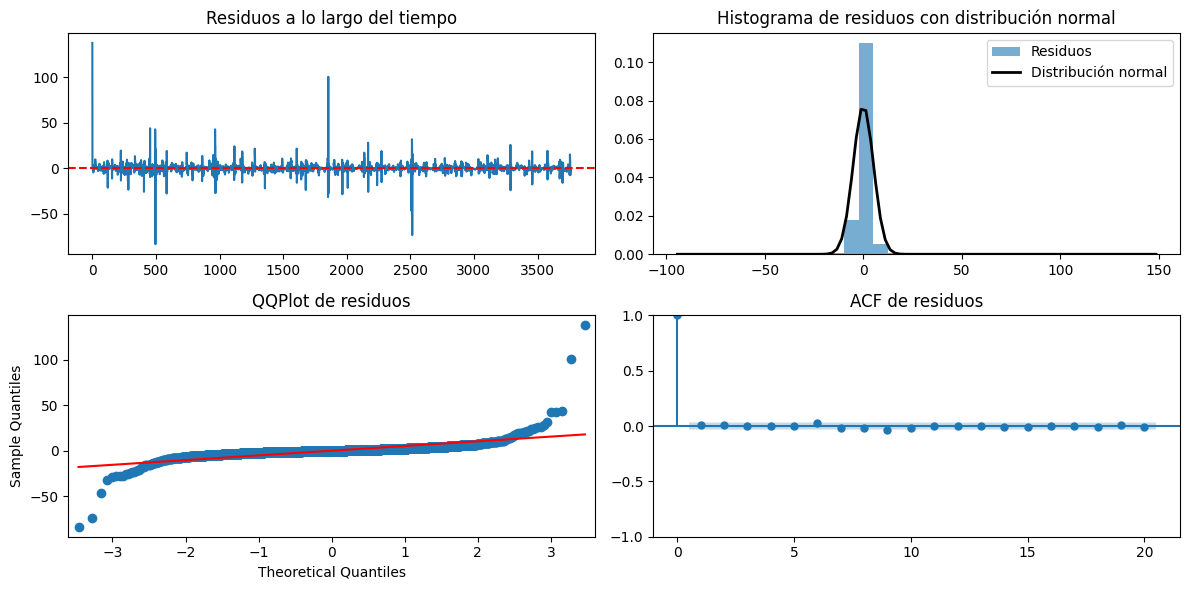

In [40]:
import numpy as np 

plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
plt.plot(residuals)
plt.title("Residuos a lo largo del tiempo")
plt.axhline(y=0, color='r', linestyle='--')

plt.subplot(2, 2, 2)
plt.hist(residuals, bins=30, density=True, alpha=0.6, label='Residuos')
mu, std = np.mean(residuals), np.std(residuals)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2, label='Distribución normal')
plt.title("Histograma de residuos con distribución normal")
plt.legend()

plt.subplot(2, 2, 3)
sm.qqplot(residuals, line='s', ax=plt.gca())
plt.title("QQPlot de residuos")

plt.subplot(2, 2, 4)
sm.graphics.tsa.plot_acf(residuals, lags=20, alpha=0.05, ax=plt.gca())
plt.title("ACF de residuos")

plt.tight_layout()
plt.show()

### Quantitative analsyis

We Ljung-Box test establish that the residuals are independently distributed as null hypothesis 

In [41]:
lags = np.arange(1, 11, 1)
df_residuals = acorr_ljungbox(residuals, lags)
df_residuals['Lag k'] = np.arange(1, 11)

We can conclude residuals are not independent since we can't reject null hypothesis

In [42]:
df_residuals

,lb_stat,lb_pvalue,Lag k
1,0.134818,0.713488,1
2,0.546980,0.760720,2
3,0.547708,0.908292,3
4,0.619389,0.960885,4
5,0.620894,0.987027,5
6,2.816143,0.831544,6
7,3.673916,0.816476,7
8,4.462831,0.813140,8
9,9.585563,0.385065,9
10,10.804223,0.372973,10


## Make predictions 

In [48]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int,
                     window: int, method: str, theta: float=None, 
                     order_ma: int=None, order_ar: int=None, order_arma: tuple=None) -> list:
    
    total_len = train_len + horizon
    
    if method == 'mean':
        pred_mean = []
        
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))

        return pred_mean

    elif method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value

    elif method == 'simple':
        if theta == None:
            theta=0.5
        
        def alisadoSimple(serie, theta):
            z = [serie[0,0]]
            for i in range(len(serie[1:])):
                z.extend(z[i-1] + (1-theta)*(serie[i]-z[i-1]))
            return z
            
        pred_simple = alisadoSimple(df[train_len:].values, theta)
        return pred_simple
        
    elif method == 'MA':
        pred_MA = []

        if order_ma == None:
            order_ma = 1
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(0,0,order_ma))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_MA.extend(oos_pred)
            
        return pred_MA

    elif method == 'AR':
        pred_AR = []

        if order_ar == None:
            order_ar = 1
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(order_ar,0,0))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_AR.extend(oos_pred)
            
        return pred_AR

    elif method == 'ARMA':
        pred_ARMA = []

        if order_arma == None:
            order_arma = (1,1)
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(order_arma[0],0,order_arma[1]))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_ARMA.extend(oos_pred)
            
        return pred_ARMA

In [43]:
print(best_model.summary())

                               SARIMAX Results                                
Dep. Variable:                glucose   No. Observations:                 3765
Model:               SARIMAX(2, 1, 4)   Log Likelihood              -11126.794
Date:                Sun, 21 Sep 2025   AIC                          22267.589
Time:                        23:32:26   BIC                          22311.221
Sample:                             0   HQIC                         22283.103
                               - 3765                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.8133      0.016    114.391      0.000       1.782       1.844
ar.L2         -0.8182      0.015    -55.691      0.000      -0.847      -0.789
ma.L1         -1.4371      0.016    -90.574      0.0

In [55]:
test_predicted = best_model.forecast(steps=len(test))
test_predicted_2 = rolling_forecast(train, len(train), len(test), 1, order_arma=(4,0), method='ARMA')

In [56]:
test_predicted

3765    161.251803
3766    159.368798
3767    157.658987
3768    156.206796
3769    154.972445
Name: predicted_mean, dtype: float64

In [57]:
test_predicted_2

[161.32271422478036,
 159.57818202647056,
 157.97400390627968,
 156.58667283415332,
 155.35403034686786]

In [58]:
test_start_idx = len(train)
test_end_idx = test_start_idx + len(test)

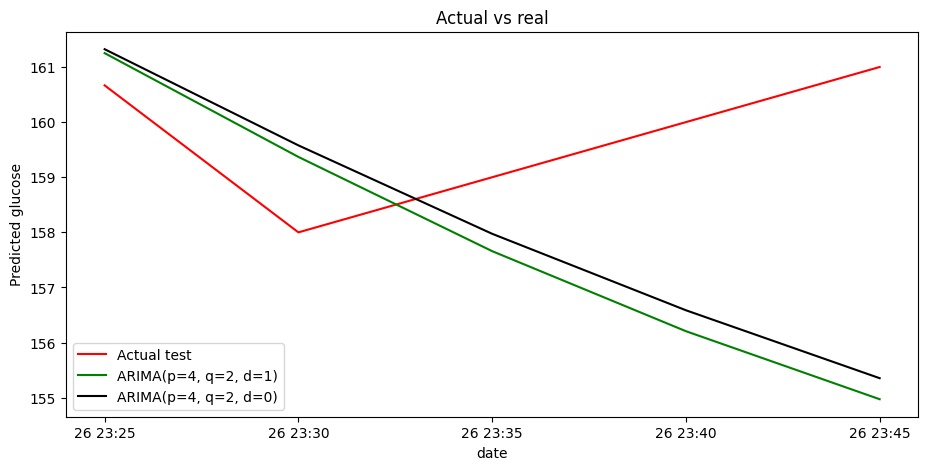

In [59]:
figure, ax = plt.subplots(1, 1, figsize=(11,5))
#ax.plot(data['time'].values[:-5], train, 'b', label='Actual train')
ax.plot(data['time'].values[-5:], test, 'r', label='Actual test')
ax.plot(data['time'].values[-5:], test_predicted, 'g', label='ARIMA(p=4, q=2, d=1)')
ax.plot(data['time'].values[-5:], test_predicted_2, 'black', label='ARIMA(p=4, q=2, d=0)')
#ax.axvspan(data['time'].values[test_start_idx], data['time'].values[test_end_idx-1], alpha=0.2, color='#808080')
ax.legend()
ax.set(title='Actual vs real', xlabel='date', ylabel='Predicted glucose')
plt.show()